Starting enhanced waveguide analysis...
=== ENHANCED WAVEGUIDE ANALYSIS WITH FIELD PROFILES ===

Analyzing Case 1: Optimal_Smooth_1480
  n_eff = 2.9557
  Γ_Si Core = 0.9574
  Γ_Al2O3 Clad = 0.0276
  Γ_BOX = 0.0085
  Γ_Air = 0.0065

Analyzing Case 2: Optimal_Rough_1480
  n_eff = 2.6966
  Γ_Si Core = 0.9438
  Γ_Al2O3 Clad = 0.0340
  Γ_BOX = 0.0128
  Γ_Air = 0.0093

Analyzing Case 3: Large_Smooth_1550
  n_eff = 3.0114
  Γ_Si Core = 0.9579
  Γ_Al2O3 Clad = 0.0260
  Γ_BOX = 0.0091
  Γ_Air = 0.0070

Analyzing Case 4: Large_Rough_1550
  n_eff = 2.8024
  Γ_Si Core = 0.9476
  Γ_Al2O3 Clad = 0.0308
  Γ_BOX = 0.0124
  Γ_Air = 0.0093

Generating visualizations...


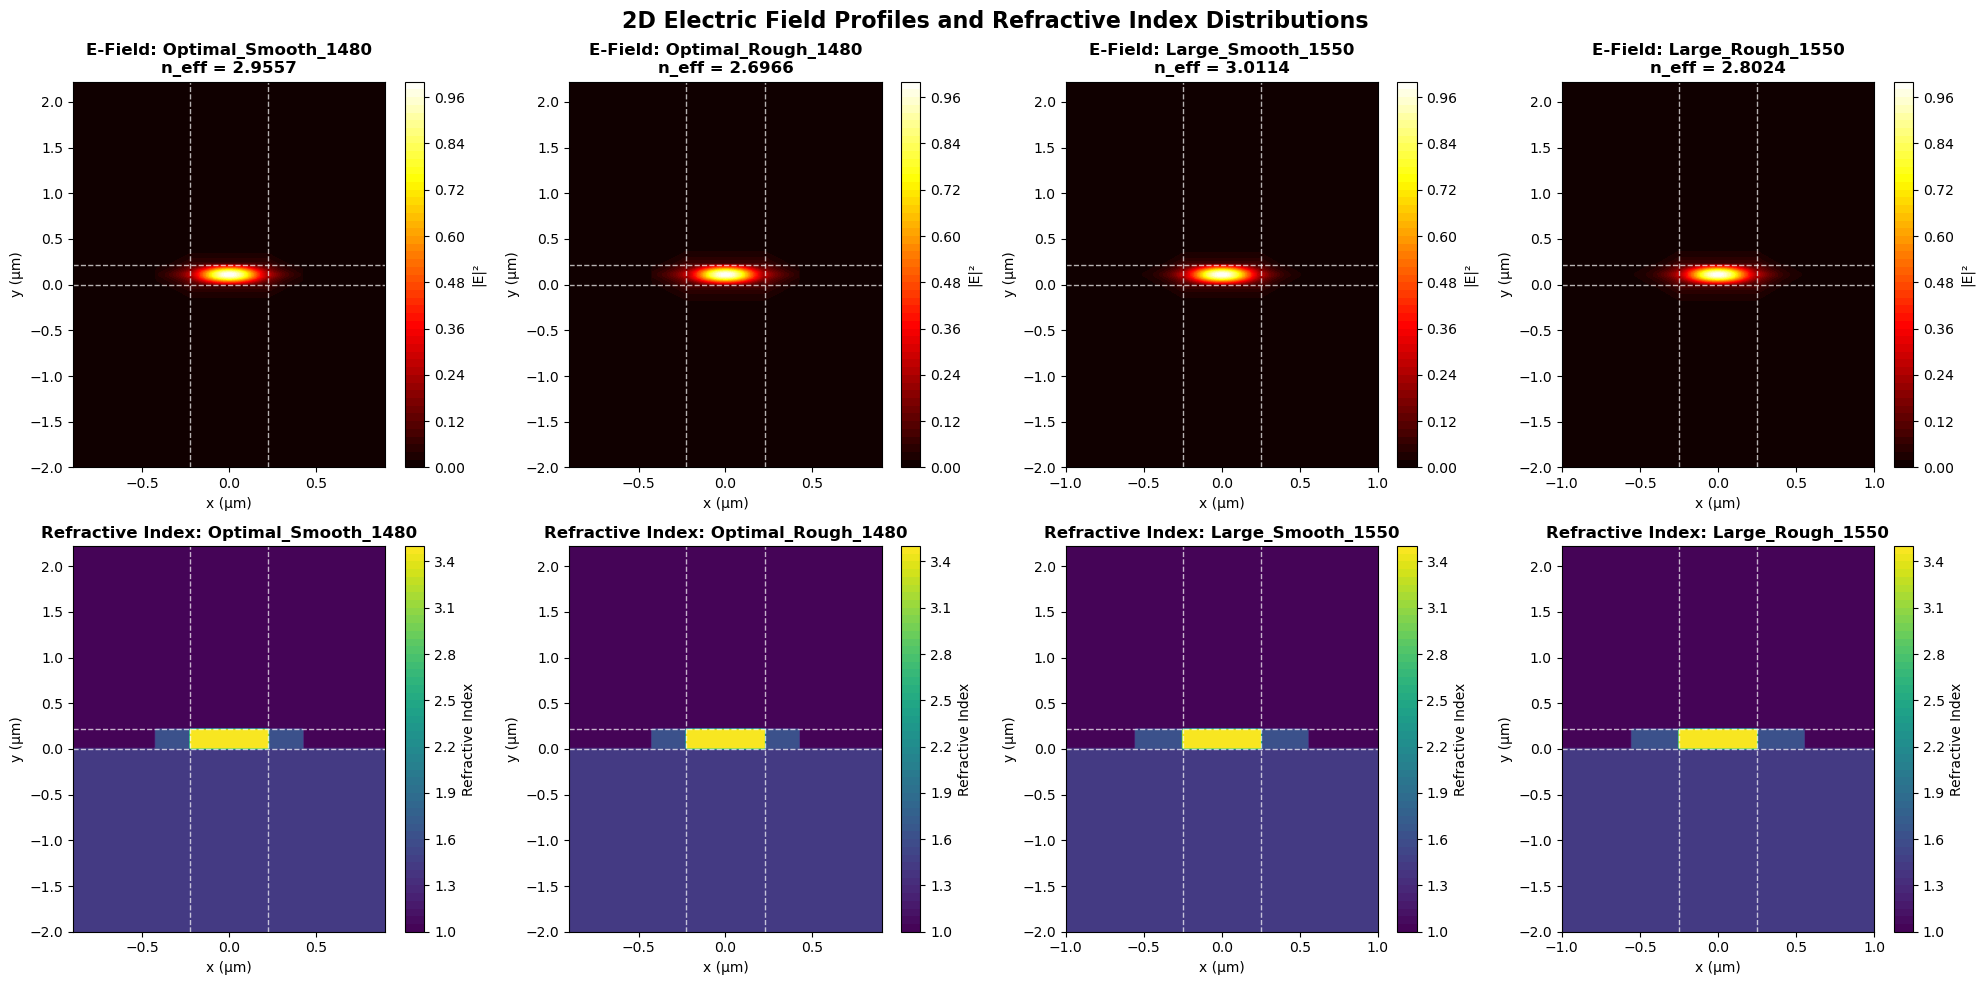

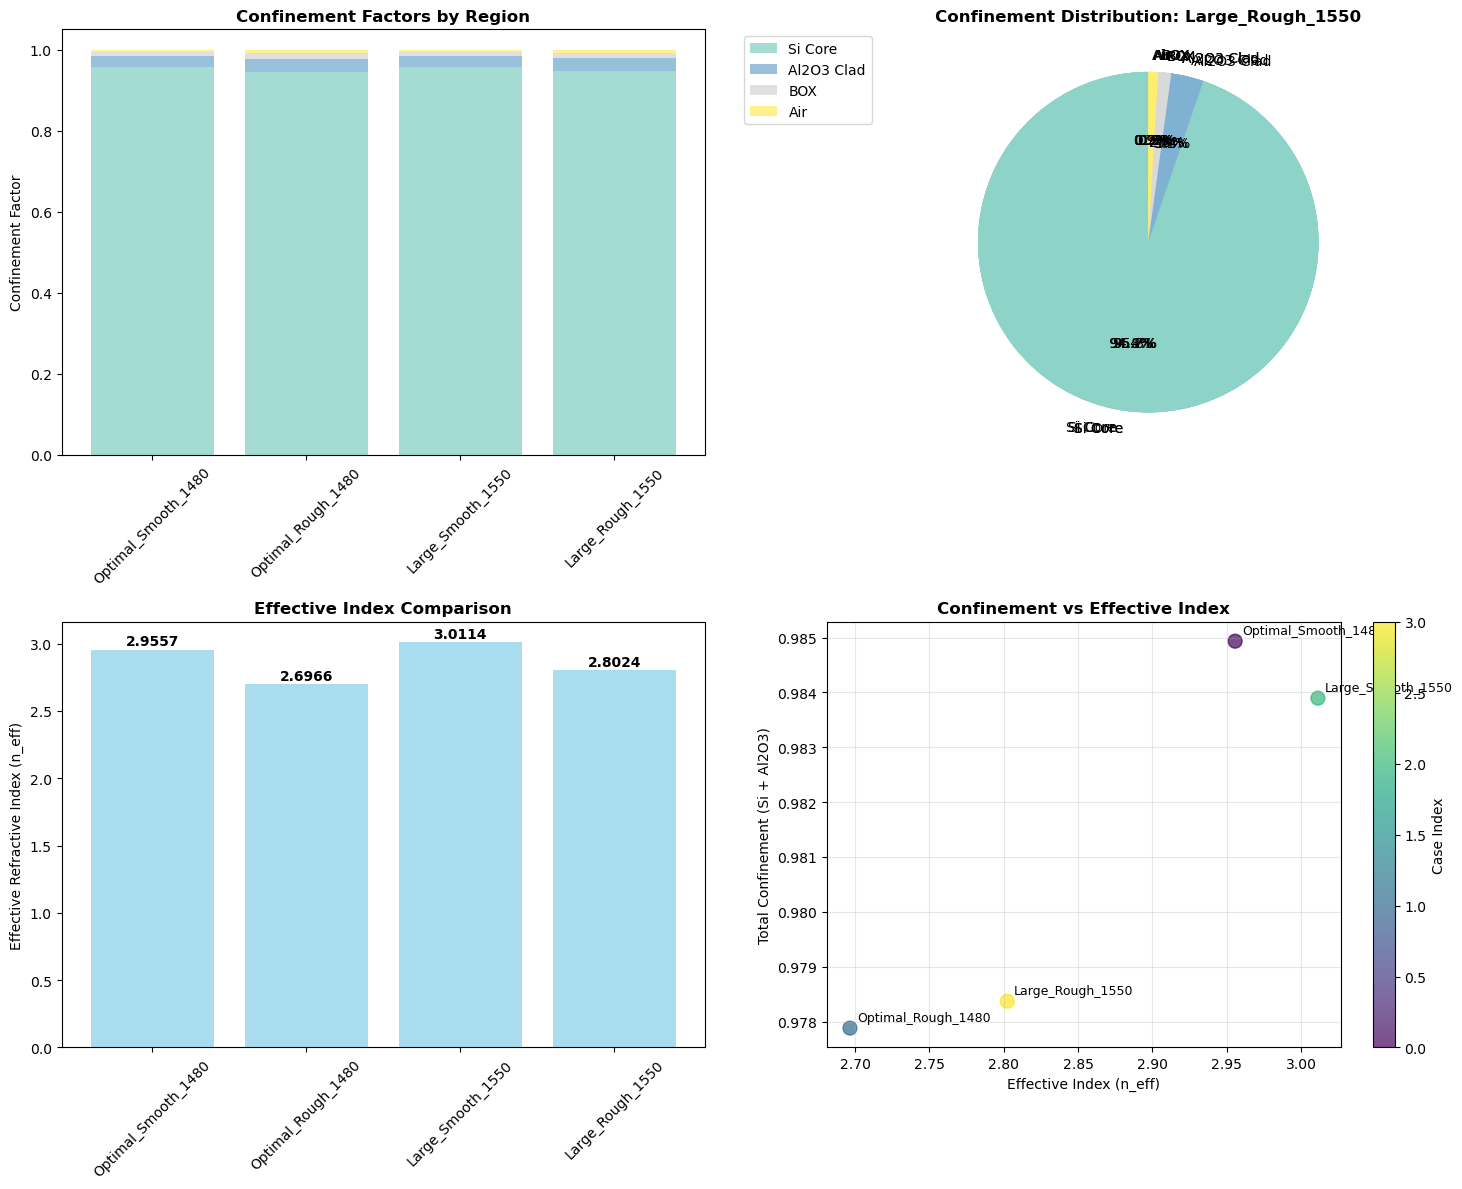

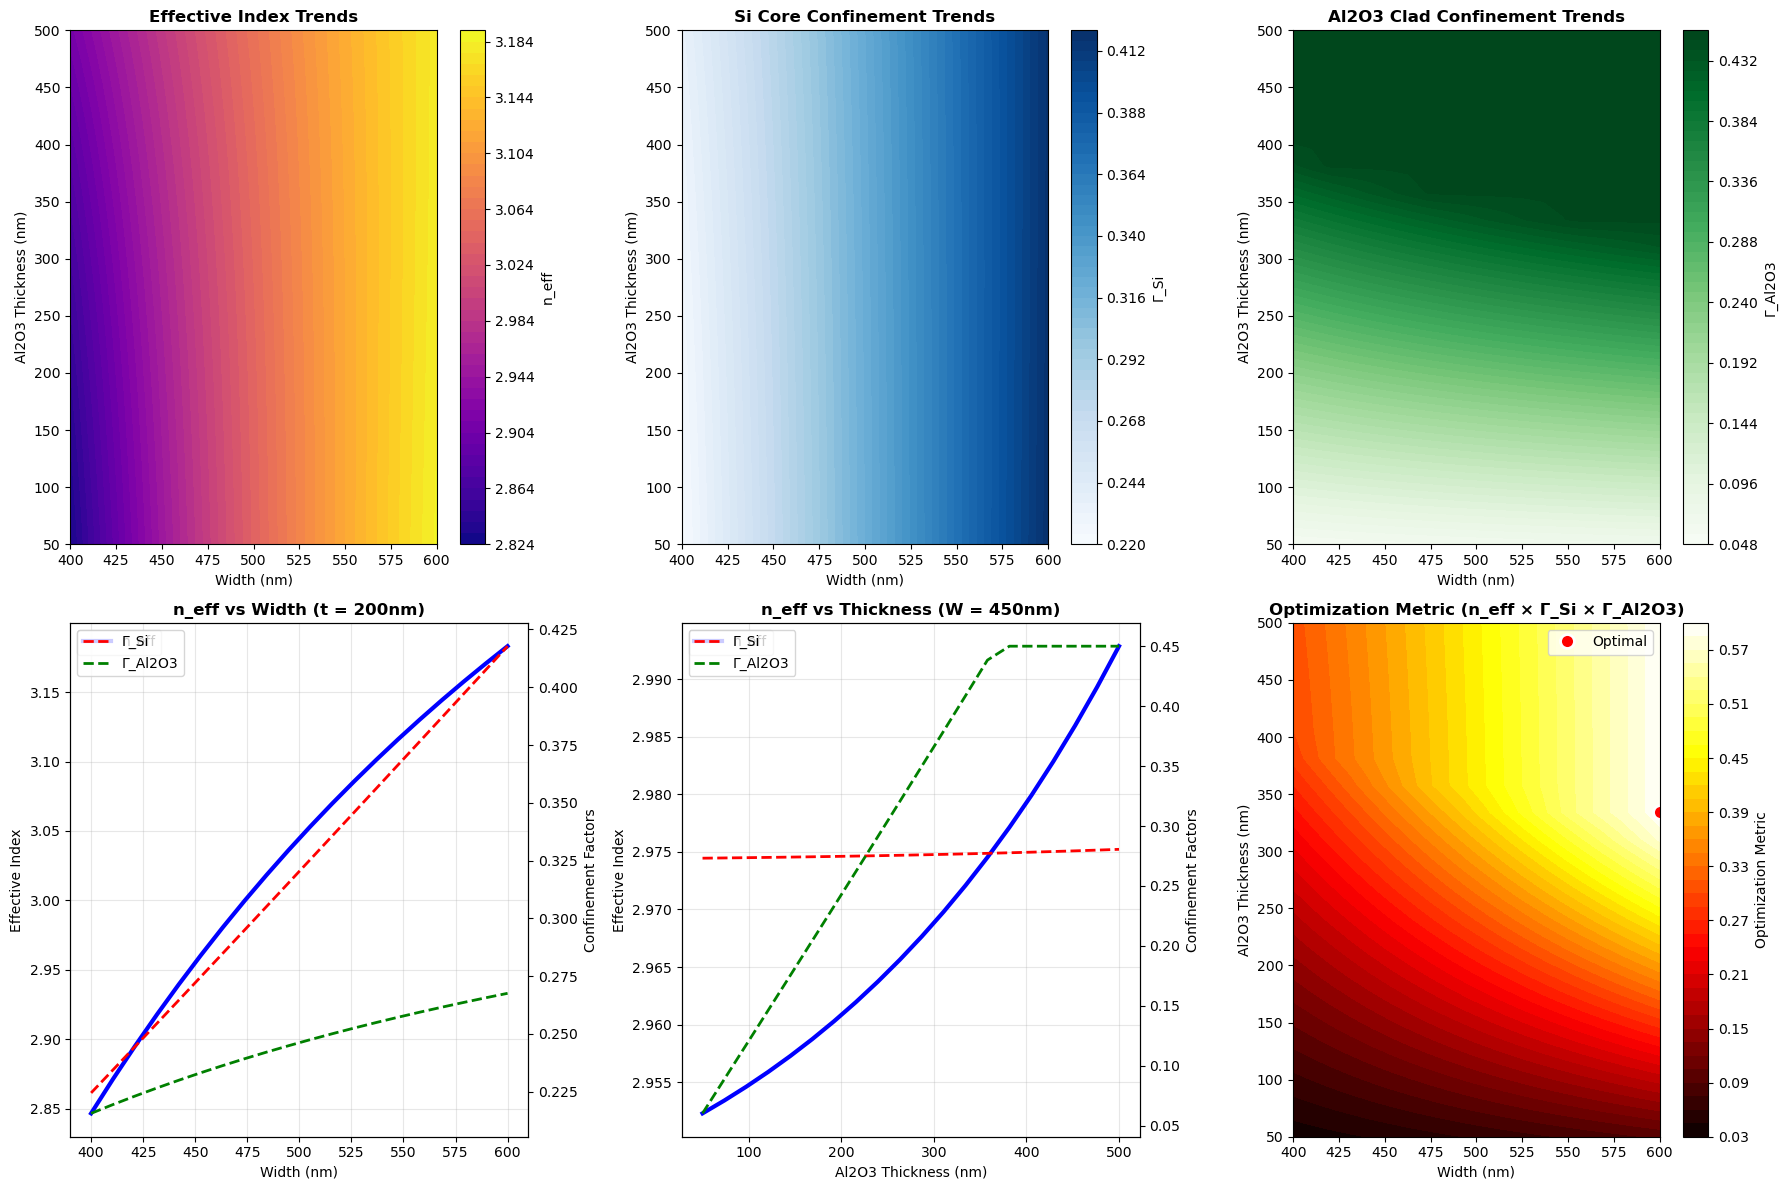

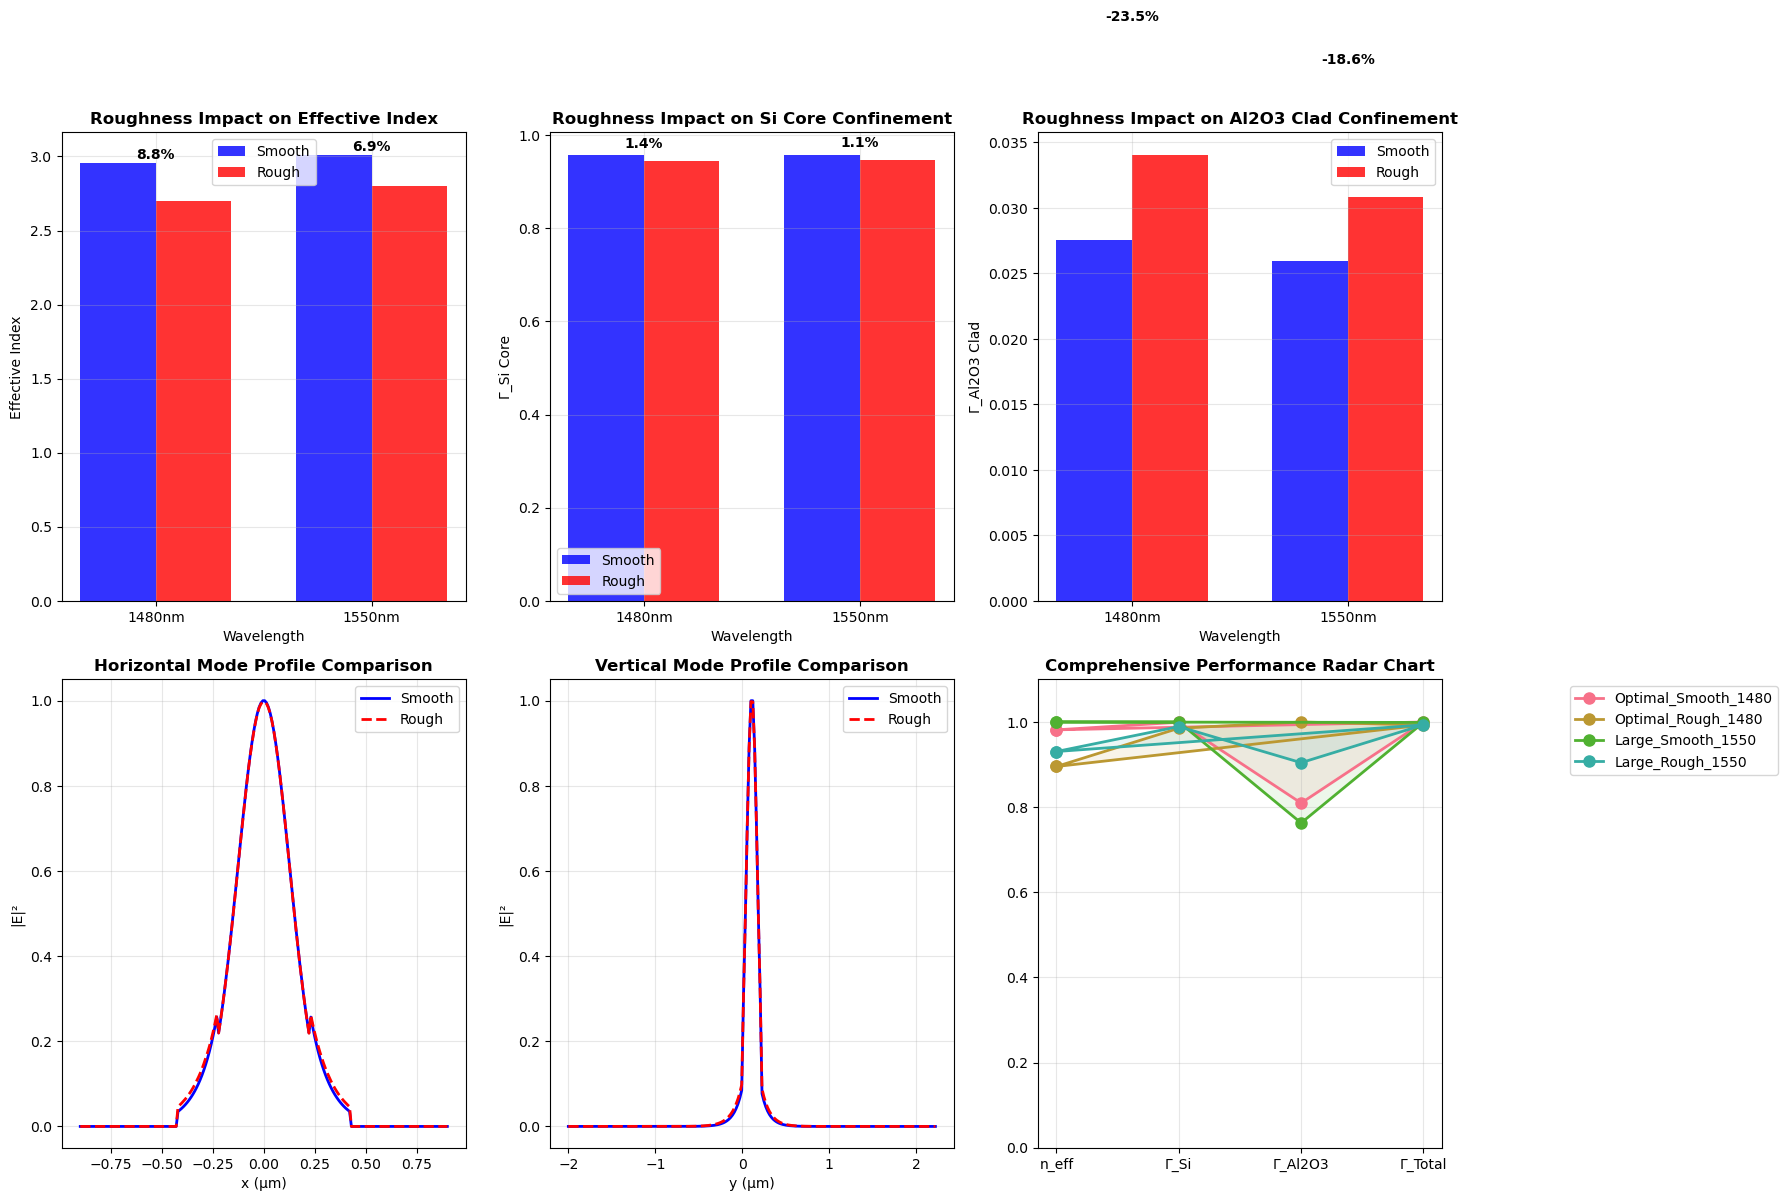

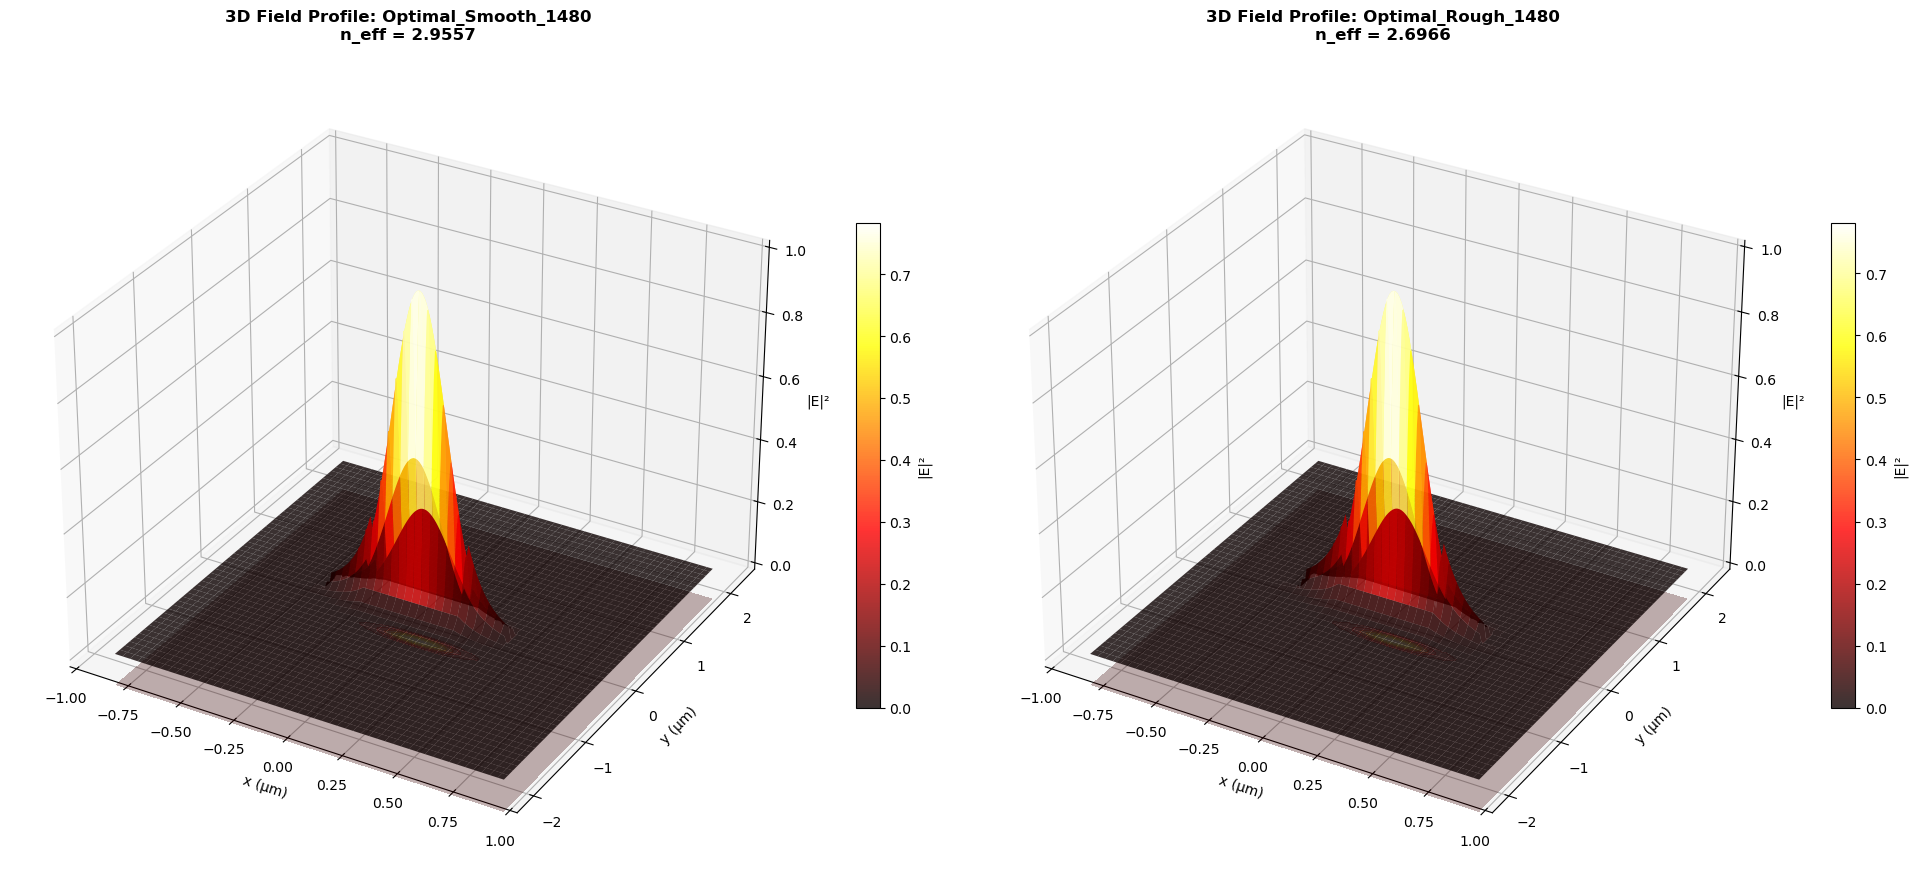


COMPREHENSIVE WAVEGUIDE ANALYSIS SUMMARY REPORT

WAVEGUIDE PARAMETERS:
  Silicon height: 220 nm
  BOX thickness: 2.0 μm
  Air cladding height: 2.0 μm
  Sidewall roughness: 50 nm

MATERIAL PROPERTIES:
  Silicon core: n = 3.48
  Al₂O₃ cladding: n = 1.63
  BOX: n = 1.444
  Air: n = 1.0

DETAILED ANALYSIS RESULTS:
------------------------------------------------------------

Case: Optimal_Smooth_1480
  Wavelength: 1480 nm
  Width: 450 nm
  Al₂O₃ thickness: 200 nm
  Roughness included: False
  Effective index: 2.9557
  Confinement Factors:
    Si Core: 0.9574 (95.7%)
    Al2O3 Clad: 0.0276 (2.8%)
    BOX: 0.0085 (0.9%)
    Air: 0.0065 (0.7%)
  Total useful confinement: 0.9849 (98.5%)

Case: Optimal_Rough_1480
  Wavelength: 1480 nm
  Width: 450 nm
  Al₂O₃ thickness: 200 nm
  Roughness included: True
  Effective index: 2.6966
  Confinement Factors:
    Si Core: 0.9438 (94.4%)
    Al2O3 Clad: 0.0340 (3.4%)
    BOX: 0.0128 (1.3%)
    Air: 0.0093 (0.9%)
  Total useful confinement: 0.9779 (97.8%

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import cm
import seaborn as sns
from scipy import constants
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

class EnhancedWaveguideAnalyzer:
    def __init__(self):
        # Waveguide Parameters
        self.lambda1 = 1480e-9    # Wavelength 1 [m]
        self.lambda2 = 1550e-9    # Wavelength 2 [m]
        self.c = constants.c      # Speed of light [m/s]
        
        # Refractive indices
        self.n_si = 3.48          # Silicon core
        self.n_al2o3 = 1.63       # Aluminum oxide cladding
        self.n_air = 1.00         # Air cladding
        self.n_box = 1.444        # Buried oxide
        
        # Fixed dimensions
        self.h_si = 220e-9        # Silicon height [m]
        self.h_box = 2e-6         # BOx thickness [m]
        self.h_air = 2e-6         # Air cladding height [m]
        self.roughness = 50e-9    # Sidewall roughness [m]
        
        # Optimization ranges
        self.t_range = np.linspace(50e-9, 500e-9, 25)
        self.W_range = np.linspace(400e-9, 600e-9, 25)
        
        # Field simulation parameters
        self.nx, self.ny = 200, 200  # Grid points for field profiles
        self.results = {}
        
    def calculate_effective_index(self, W, h_si, n_core, n_clad, lambda_val):
        """Calculate effective index using analytical approximation"""
        k0 = 2 * np.pi / lambda_val
        
        # Simplified effective index calculation for rectangular waveguide
        V = k0 * W * np.sqrt(n_core**2 - n_clad**2) / 2
        b = (1.1428 - 0.9960/V)**2 if V > 1.5 else V**2/(2 + V**2)
        neff = np.sqrt(n_clad**2 + b * (n_core**2 - n_clad**2))
        
        return max(n_clad, min(n_core, neff))
    
    def calculate_electric_field_profile(self, W, h_si, t, roughness, use_roughness, lambda_val):
        """Calculate 2D electric field profile for the waveguide"""
        # Create coordinate system
        x = np.linspace(-W*2, W*2, self.nx)
        y = np.linspace(-self.h_box, self.h_air + h_si, self.ny)
        X, Y = np.meshgrid(x, y)
        
        # Define material regions
        si_region = (np.abs(X) <= W/2) & (Y >= 0) & (Y <= h_si)
        al2o3_region = (np.abs(X) <= W/2 + t) & (Y >= 0) & (Y <= h_si)
        al2o3_region = al2o3_region & ~si_region
        box_region = Y < 0
        air_region = Y > h_si
        
        # Create refractive index distribution
        n_profile = np.ones_like(X) * self.n_air
        n_profile[box_region] = self.n_box
        n_profile[si_region] = self.n_si
        n_profile[al2o3_region] = self.n_al2o3
        
        # Calculate average cladding index for effective index calculation
        n_clad_avg = (self.n_al2o3 * 2 * t + self.n_air * (W - 2 * t) + self.n_box * h_si) / (2 * t + W - 2 * t + h_si)
        
        # Calculate effective index
        if use_roughness:
            W_eff = max(W - 2 * roughness, 10e-9)
            t_eff = max(t - roughness, 0)
            n_core_eff = self.n_si * (1 - 0.01 * (roughness / (W/2)))
            neff = self.calculate_effective_index(W_eff, h_si, n_core_eff, n_clad_avg, lambda_val)
        else:
            neff = self.calculate_effective_index(W, h_si, self.n_si, n_clad_avg, lambda_val)
        
        # Create Gaussian-like field profile (approximation of fundamental mode)
        beta = 2 * np.pi * neff / lambda_val
        k0 = 2 * np.pi / lambda_val
        
        # Field in silicon core (Gaussian approximation)
        w0_x = W / 2.5  # Beam waist in x
        w0_y = h_si / 2.5  # Beam waist in y
        
        E_field = np.zeros_like(X)
        
        # Core field (strong confinement)
        core_mask = si_region
        x_centered = X[core_mask]
        y_centered = Y[core_mask] - h_si/2
        
        E_field[core_mask] = np.exp(-(x_centered**2 / w0_x**2 + y_centered**2 / w0_y**2))
        
        # Cladding fields (exponential decay)
        for region, n_region in [(al2o3_region, self.n_al2o3), (box_region, self.n_box), 
                                (air_region, self.n_air)]:
            if np.any(region):
                # Distance from core
                dist_x = np.maximum(np.abs(X[region]) - W/2, 0)
                dist_y_core = np.abs(Y[region] - h_si/2)
                
                # Decay constant
                gamma = k0 * np.sqrt(max(0, neff**2 - n_region**2))
                
                # Exponential decay from core
                if gamma > 0:
                    E_field[region] = np.exp(-gamma * (dist_x + dist_y_core)) * 0.3
        
        # Normalize field
        if np.max(E_field) > 0:
            E_field = E_field / np.max(E_field)
        
        # Add roughness effects if enabled
        if use_roughness and roughness > 0:
            # Create roughness pattern
            roughness_pattern = np.random.normal(0, 0.1, E_field.shape)
            roughness_pattern = gaussian_filter(roughness_pattern, sigma=2)
            E_field = E_field * (1 - 0.2 * np.abs(roughness_pattern))
            E_field = np.clip(E_field, 0, 1)
        
        return X, Y, E_field, n_profile, neff
    
    def calculate_confinement_factors_2d(self, X, Y, E_field, regions):
        """Calculate 2D confinement factors in different regions"""
        # Calculate power density (|E|^2)
        power_density = E_field**2
        
        # Avoid division by zero
        if np.sum(power_density) == 0:
            return {region: 0.0 for region in regions.keys()}
        
        total_power = np.sum(power_density)
        
        confinement_factors = {}
        for region_name, region_mask in regions.items():
            region_power = np.sum(power_density[region_mask])
            confinement_factors[region_name] = region_power / total_power if total_power > 0 else 0
        
        return confinement_factors
    
    def run_enhanced_analysis(self):
        """Run comprehensive analysis with field profiles"""
        print("=== ENHANCED WAVEGUIDE ANALYSIS WITH FIELD PROFILES ===")
        
        # Test cases for detailed analysis
        test_cases = [
            {'W': 450e-9, 't': 200e-9, 'roughness': False, 'lambda_val': self.lambda1, 'label': 'Optimal_Smooth_1480'},
            {'W': 450e-9, 't': 200e-9, 'roughness': True, 'lambda_val': self.lambda1, 'label': 'Optimal_Rough_1480'},
            {'W': 500e-9, 't': 300e-9, 'roughness': False, 'lambda_val': self.lambda2, 'label': 'Large_Smooth_1550'},
            {'W': 500e-9, 't': 300e-9, 'roughness': True, 'lambda_val': self.lambda2, 'label': 'Large_Rough_1550'},
        ]
        
        field_results = {}
        
        for i, case in enumerate(test_cases):
            print(f"\nAnalyzing Case {i+1}: {case['label']}")
            
            X, Y, E_field, n_profile, neff = self.calculate_electric_field_profile(
                case['W'], self.h_si, case['t'], self.roughness, 
                case['roughness'], case['lambda_val']
            )
            
            # Define regions for confinement calculation
            regions = {
                'Si Core': (np.abs(X) <= case['W']/2) & (Y >= 0) & (Y <= self.h_si),
                'Al2O3 Clad': (np.abs(X) <= case['W']/2 + case['t']) & (Y >= 0) & (Y <= self.h_si) & 
                             ~(np.abs(X) <= case['W']/2) & (Y >= 0) & (Y <= self.h_si),
                'BOX': Y < 0,
                'Air': Y > self.h_si
            }
            
            confinement_factors = self.calculate_confinement_factors_2d(X, Y, E_field, regions)
            
            field_results[case['label']] = {
                'X': X, 'Y': Y, 'E_field': E_field, 'n_profile': n_profile,
                'neff': neff, 'confinement_factors': confinement_factors,
                'parameters': case
            }
            
            print(f"  n_eff = {neff:.4f}")
            for region, gamma in confinement_factors.items():
                print(f"  Γ_{region} = {gamma:.4f}")
        
        self.field_results = field_results
        return field_results
    
    def plot_enhanced_visualizations(self):
        """Create comprehensive enhanced visualizations"""
        plt.style.use('default')
        sns.set_palette("husl")
        
        self._plot_field_profiles()
        self._plot_confinement_analysis()
        self._plot_trend_analysis()
        self._plot_comparative_analysis()
        self._plot_3d_field_profiles()
    
    def _plot_field_profiles(self):
        """Plot 2D electric field profiles and refractive index distributions"""
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle('2D Electric Field Profiles and Refractive Index Distributions', 
                    fontsize=16, fontweight='bold')
        
        cases = list(self.field_results.keys())
        
        for i, case in enumerate(cases):
            data = self.field_results[case]
            X, Y, E_field, n_profile = data['X'], data['Y'], data['E_field'], data['n_profile']
            
            # Electric field profile
            im1 = axes[0, i].contourf(X*1e6, Y*1e6, E_field, levels=50, cmap='hot')
            axes[0, i].set_title(f'E-Field: {case}\nn_eff = {data["neff"]:.4f}', fontweight='bold')
            axes[0, i].set_xlabel('x (μm)')
            axes[0, i].set_ylabel('y (μm)')
            plt.colorbar(im1, ax=axes[0, i], label='|E|²')
            
            # Refractive index profile
            im2 = axes[1, i].contourf(X*1e6, Y*1e6, n_profile, levels=50, cmap='viridis')
            axes[1, i].set_title(f'Refractive Index: {case}', fontweight='bold')
            axes[1, i].set_xlabel('x (μm)')
            axes[1, i].set_ylabel('y (μm)')
            plt.colorbar(im2, ax=axes[1, i], label='Refractive Index')
            
            # Add waveguide boundaries
            for ax in [axes[0, i], axes[1, i]]:
                W = data['parameters']['W']
                ax.axvline(x=-W/2*1e6, color='white', linestyle='--', alpha=0.7, linewidth=1)
                ax.axvline(x=W/2*1e6, color='white', linestyle='--', alpha=0.7, linewidth=1)
                ax.axhline(y=0, color='white', linestyle='--', alpha=0.7, linewidth=1)
                ax.axhline(y=self.h_si*1e6, color='white', linestyle='--', alpha=0.7, linewidth=1)
        
        plt.tight_layout()
        plt.savefig('field_profiles_2d.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_confinement_analysis(self):
        """Plot comprehensive confinement factor analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        cases = list(self.field_results.keys())
        regions = ['Si Core', 'Al2O3 Clad', 'BOX', 'Air']
        colors = plt.cm.Set3(np.linspace(0, 1, len(regions)))
        
        # Stacked bar chart of confinement factors
        gamma_data = []
        for case in cases:
            data = self.field_results[case]
            gamma_data.append([data['confinement_factors'][region] for region in regions])
        
        gamma_data = np.array(gamma_data)
        
        # Stacked bar plot
        bottom = np.zeros(len(cases))
        for i, region in enumerate(regions):
            axes[0, 0].bar(cases, gamma_data[:, i], bottom=bottom, label=region, color=colors[i], alpha=0.8)
            bottom += gamma_data[:, i]
        
        axes[0, 0].set_ylabel('Confinement Factor')
        axes[0, 0].set_title('Confinement Factors by Region', fontweight='bold')
        axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Pie charts for each case
        for i, case in enumerate(cases):
            data = self.field_results[case]
            wedges, texts, autotexts = axes[0, 1].pie(
                [data['confinement_factors'][region] for region in regions],
                labels=regions, autopct='%1.1f%%', startangle=90,
                colors=colors
            )
            axes[0, 1].set_title(f'Confinement Distribution: {case}', fontweight='bold')
        
        # Effective index comparison
        neff_values = [self.field_results[case]['neff'] for case in cases]
        bars = axes[1, 0].bar(cases, neff_values, color='skyblue', alpha=0.7)
        axes[1, 0].set_ylabel('Effective Refractive Index (n_eff)')
        axes[1, 0].set_title('Effective Index Comparison', fontweight='bold')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, neff_values):
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                           f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        
        # Confinement efficiency plot
        total_confinement = np.sum(gamma_data[:, :2], axis=1)  # Si + Al2O3
        scatter = axes[1, 1].scatter(neff_values, total_confinement, s=100, c=range(len(cases)), 
                                   cmap='viridis', alpha=0.7)
        
        for i, case in enumerate(cases):
            axes[1, 1].annotate(case, (neff_values[i], total_confinement[i]), 
                               xytext=(5, 5), textcoords='offset points', fontsize=9)
        
        axes[1, 1].set_xlabel('Effective Index (n_eff)')
        axes[1, 1].set_ylabel('Total Confinement (Si + Al2O3)')
        axes[1, 1].set_title('Confinement vs Effective Index', fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.colorbar(scatter, ax=axes[1, 1], label='Case Index')
        
        plt.tight_layout()
        plt.savefig('confinement_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_trend_analysis(self):
        """Plot parameter trend analysis"""
        # Generate trend data
        W_test = np.linspace(400e-9, 600e-9, 20)
        t_test = np.linspace(50e-9, 500e-9, 20)
        
        neff_trend = np.zeros((len(t_test), len(W_test)))
        gamma_si_trend = np.zeros((len(t_test), len(W_test)))
        gamma_al2o3_trend = np.zeros((len(t_test), len(W_test)))
        
        for i, t in enumerate(t_test):
            for j, W in enumerate(W_test):
                # Calculate average cladding index
                n_clad_avg = (self.n_al2o3 * 2 * t + self.n_air * (W - 2 * t) + self.n_box * self.h_si) / (2 * t + W - 2 * t + self.h_si)
                neff = self.calculate_effective_index(W, self.h_si, self.n_si, n_clad_avg, self.lambda1)
                neff_trend[i, j] = neff
                
                # Simplified confinement trends
                A_si = W * self.h_si
                A_al2o3 = 2 * t * self.h_si
                A_mode = (self.lambda1/2)**2 / max(0.1, neff - 1.45)
                
                gamma_si_trend[i, j] = min(A_si / A_mode, 0.95)
                gamma_al2o3_trend[i, j] = min(A_al2o3 / A_mode, 0.45)
        
        # Create trend plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Effective index trends
        im1 = axes[0, 0].contourf(W_test*1e9, t_test*1e9, neff_trend, levels=50, cmap='plasma')
        axes[0, 0].set_xlabel('Width (nm)')
        axes[0, 0].set_ylabel('Al2O3 Thickness (nm)')
        axes[0, 0].set_title('Effective Index Trends', fontweight='bold')
        plt.colorbar(im1, ax=axes[0, 0], label='n_eff')
        
        # Si confinement trends
        im2 = axes[0, 1].contourf(W_test*1e9, t_test*1e9, gamma_si_trend, levels=50, cmap='Blues')
        axes[0, 1].set_xlabel('Width (nm)')
        axes[0, 1].set_ylabel('Al2O3 Thickness (nm)')
        axes[0, 1].set_title('Si Core Confinement Trends', fontweight='bold')
        plt.colorbar(im2, ax=axes[0, 1], label='Γ_Si')
        
        # Al2O3 confinement trends
        im3 = axes[0, 2].contourf(W_test*1e9, t_test*1e9, gamma_al2o3_trend, levels=50, cmap='Greens')
        axes[0, 2].set_xlabel('Width (nm)')
        axes[0, 2].set_ylabel('Al2O3 Thickness (nm)')
        axes[0, 2].set_title('Al2O3 Clad Confinement Trends', fontweight='bold')
        plt.colorbar(im3, ax=axes[0, 2], label='Γ_Al2O3')
        
        # Cross-sectional trends
        t_fixed = 200e-9
        t_idx = np.argmin(np.abs(t_test - t_fixed))
        
        axes[1, 0].plot(W_test*1e9, neff_trend[t_idx, :], 'b-', linewidth=3, label='n_eff')
        axes[1, 0].set_xlabel('Width (nm)')
        axes[1, 0].set_ylabel('Effective Index')
        axes[1, 0].set_title(f'n_eff vs Width (t = {t_fixed*1e9:.0f}nm)', fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()
        
        ax2 = axes[1, 0].twinx()
        ax2.plot(W_test*1e9, gamma_si_trend[t_idx, :], 'r--', linewidth=2, label='Γ_Si')
        ax2.plot(W_test*1e9, gamma_al2o3_trend[t_idx, :], 'g--', linewidth=2, label='Γ_Al2O3')
        ax2.set_ylabel('Confinement Factors')
        ax2.legend()
        
        # Thickness trends
        W_fixed = 450e-9
        W_idx = np.argmin(np.abs(W_test - W_fixed))
        
        axes[1, 1].plot(t_test*1e9, neff_trend[:, W_idx], 'b-', linewidth=3, label='n_eff')
        axes[1, 1].set_xlabel('Al2O3 Thickness (nm)')
        axes[1, 1].set_ylabel('Effective Index')
        axes[1, 1].set_title(f'n_eff vs Thickness (W = {W_fixed*1e9:.0f}nm)', fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend()
        
        ax2 = axes[1, 1].twinx()
        ax2.plot(t_test*1e9, gamma_si_trend[:, W_idx], 'r--', linewidth=2, label='Γ_Si')
        ax2.plot(t_test*1e9, gamma_al2o3_trend[:, W_idx], 'g--', linewidth=2, label='Γ_Al2O3')
        ax2.set_ylabel('Confinement Factors')
        ax2.legend()
        
        # Optimization metric
        optimization_metric = neff_trend * gamma_si_trend * gamma_al2o3_trend
        im4 = axes[1, 2].contourf(W_test*1e9, t_test*1e9, optimization_metric, levels=50, cmap='hot')
        axes[1, 2].set_xlabel('Width (nm)')
        axes[1, 2].set_ylabel('Al2O3 Thickness (nm)')
        axes[1, 2].set_title('Optimization Metric (n_eff × Γ_Si × Γ_Al2O3)', fontweight='bold')
        plt.colorbar(im4, ax=axes[1, 2], label='Optimization Metric')
        
        # Mark optimal point
        opt_idx = np.unravel_index(np.argmax(optimization_metric), optimization_metric.shape)
        axes[1, 2].plot(W_test[opt_idx[1]]*1e9, t_test[opt_idx[0]]*1e9, 'ro', markersize=10, 
                       markeredgecolor='white', markeredgewidth=2, label='Optimal')
        axes[1, 2].legend()
        
        plt.tight_layout()
        plt.savefig('parameter_trends.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_comparative_analysis(self):
        """Plot comparative analysis between smooth and rough waveguides"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Compare key parameters
        cases = list(self.field_results.keys())
        smooth_cases = [c for c in cases if 'Smooth' in c]
        rough_cases = [c for c in cases if 'Rough' in c]
        
        # Effective index comparison
        smooth_neff = [self.field_results[c]['neff'] for c in smooth_cases]
        rough_neff = [self.field_results[c]['neff'] for c in rough_cases]
        
        x_pos = np.arange(len(smooth_cases))
        width = 0.35
        
        bars1 = axes[0, 0].bar(x_pos - width/2, smooth_neff, width, label='Smooth', alpha=0.8, color='blue')
        bars2 = axes[0, 0].bar(x_pos + width/2, rough_neff, width, label='Rough', alpha=0.8, color='red')
        
        axes[0, 0].set_xlabel('Wavelength')
        axes[0, 0].set_ylabel('Effective Index')
        axes[0, 0].set_title('Roughness Impact on Effective Index', fontweight='bold')
        axes[0, 0].set_xticks(x_pos)
        axes[0, 0].set_xticklabels(['1480nm', '1550nm'])
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Add percentage change annotations
        for i, (smooth, rough) in enumerate(zip(smooth_neff, rough_neff)):
            change_pct = (smooth - rough) / smooth * 100
            axes[0, 0].text(i, max(smooth, rough) + 0.01, f'{change_pct:.1f}%', 
                           ha='center', va='bottom', fontweight='bold')
        
        # Confinement factor comparison
        regions = ['Si Core', 'Al2O3 Clad']
        for j, region in enumerate(regions):
            smooth_gamma = [self.field_results[c]['confinement_factors'][region] for c in smooth_cases]
            rough_gamma = [self.field_results[c]['confinement_factors'][region] for c in rough_cases]
            
            axes[0, 1+j].bar(x_pos - width/2, smooth_gamma, width, label='Smooth', alpha=0.8, color='blue')
            axes[0, 1+j].bar(x_pos + width/2, rough_gamma, width, label='Rough', alpha=0.8, color='red')
            
            axes[0, 1+j].set_xlabel('Wavelength')
            axes[0, 1+j].set_ylabel(f'Γ_{region}')
            axes[0, 1+j].set_title(f'Roughness Impact on {region} Confinement', fontweight='bold')
            axes[0, 1+j].set_xticks(x_pos)
            axes[0, 1+j].set_xticklabels(['1480nm', '1550nm'])
            axes[0, 1+j].legend()
            axes[0, 1+j].grid(True, alpha=0.3)
            
            # Add percentage changes
            for i, (smooth, rough) in enumerate(zip(smooth_gamma, rough_gamma)):
                change_pct = (smooth - rough) / smooth * 100
                axes[0, 1+j].text(i, max(smooth, rough) + 0.01, f'{change_pct:.1f}%', 
                                ha='center', va='bottom', fontweight='bold')
        
        # Mode profile comparison
        case1 = smooth_cases[0]
        case2 = rough_cases[0]
        
        data1 = self.field_results[case1]
        data2 = self.field_results[case2]
        
        # Horizontal cross-section
        y_center = int(data1['E_field'].shape[0] / 2)
        x_profile_smooth = data1['E_field'][y_center, :]
        x_profile_rough = data2['E_field'][y_center, :]
        
        axes[1, 0].plot(data1['X'][y_center, :]*1e6, x_profile_smooth, 'b-', linewidth=2, label='Smooth')
        axes[1, 0].plot(data2['X'][y_center, :]*1e6, x_profile_rough, 'r--', linewidth=2, label='Rough')
        axes[1, 0].set_xlabel('x (μm)')
        axes[1, 0].set_ylabel('|E|²')
        axes[1, 0].set_title('Horizontal Mode Profile Comparison', fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Vertical cross-section
        x_center = int(data1['E_field'].shape[1] / 2)
        y_profile_smooth = data1['E_field'][:, x_center]
        y_profile_rough = data2['E_field'][:, x_center]
        
        axes[1, 1].plot(data1['Y'][:, x_center]*1e6, y_profile_smooth, 'b-', linewidth=2, label='Smooth')
        axes[1, 1].plot(data2['Y'][:, x_center]*1e6, y_profile_rough, 'r--', linewidth=2, label='Rough')
        axes[1, 1].set_xlabel('y (μm)')
        axes[1, 1].set_ylabel('|E|²')
        axes[1, 1].set_title('Vertical Mode Profile Comparison', fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # Summary statistics
        summary_data = []
        for case in cases:
            data = self.field_results[case]
            summary_data.append({
                'Case': case,
                'n_eff': data['neff'],
                'Γ_Si': data['confinement_factors']['Si Core'],
                'Γ_Al2O3': data['confinement_factors']['Al2O3 Clad'],
                'Γ_Total': data['confinement_factors']['Si Core'] + data['confinement_factors']['Al2O3 Clad']
            })
        
        summary_df = pd.DataFrame(summary_data)
        
        # Radar plot for comprehensive comparison
        categories = ['n_eff', 'Γ_Si', 'Γ_Al2O3', 'Γ_Total']
        values = summary_df[categories].values
        values_normalized = values / values.max(axis=0)  # Normalize for radar plot
        
        angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        values_normalized = np.concatenate((values_normalized, values_normalized[:, :1]), axis=1)
        
        ax_radar = axes[1, 2]
        for i, case in enumerate(cases):
            values_plot = values_normalized[i]
            ax_radar.plot(angles, values_plot, 'o-', linewidth=2, label=case, markersize=8)
            ax_radar.fill(angles, values_plot, alpha=0.1)
        
        ax_radar.set_xticks(angles[:-1])
        ax_radar.set_xticklabels(categories)
        ax_radar.set_ylim(0, 1.1)
        ax_radar.set_title('Comprehensive Performance Radar Chart', fontweight='bold')
        ax_radar.legend(bbox_to_anchor=(1.3, 1), loc='upper left')
        ax_radar.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('comparative_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def _plot_3d_field_profiles(self):
        """Create 3D field profile visualizations"""
        try:
            from mpl_toolkits.mplot3d import Axes3D
            
            fig = plt.figure(figsize=(20, 10))
            
            cases = list(self.field_results.keys())[:2]  # Plot first two cases
            
            for i, case in enumerate(cases):
                data = self.field_results[case]
                X, Y, E_field = data['X'], data['Y'], data['E_field']
                
                ax = fig.add_subplot(1, 2, i+1, projection='3d')
                
                # Create surface plot
                surf = ax.plot_surface(X*1e6, Y*1e6, E_field, cmap='hot', 
                                      alpha=0.8, linewidth=0, antialiased=True)
                
                ax.set_xlabel('x (μm)')
                ax.set_ylabel('y (μm)')
                ax.set_zlabel('|E|²')
                ax.set_title(f'3D Field Profile: {case}\nn_eff = {data["neff"]:.4f}', 
                           fontweight='bold', pad=20)
                
                # Add contour projections
                offset = np.min(E_field) - 0.1
                ax.contourf(X*1e6, Y*1e6, E_field, zdir='z', offset=offset, cmap='hot', alpha=0.3)
                
                fig.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='|E|²')
            
            plt.tight_layout()
            plt.savefig('3d_field_profiles.png', dpi=300, bbox_inches='tight')
            plt.show()
            
        except ImportError:
            print("3D plotting requires mpl_toolkits, using 2D alternatives")
            self._plot_alternative_3d()
    
    def _plot_alternative_3d(self):
        """Create alternative 2D visualization when 3D plotting is not available"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        cases = list(self.field_results.keys())[:2]  # Plot first two cases
        
        for i, case in enumerate(cases):
            data = self.field_results[case]
            X, Y, E_field = data['X'], data['Y'], data['E_field']
            
            # Create enhanced 2D contour plot with multiple levels
            contour = axes[i].contourf(X*1e6, Y*1e6, E_field, levels=100, cmap='hot')
            axes[i].set_xlabel('x (μm)')
            axes[i].set_ylabel('y (μm)')
            axes[i].set_title(f'Enhanced 2D Field: {case}\nn_eff = {data["neff"]:.4f}', 
                           fontweight='bold')
            
            # Add contour lines
            axes[i].contour(X*1e6, Y*1e6, E_field, levels=10, colors='white', alpha=0.3, linewidths=0.5)
            
            # Add waveguide boundaries
            W = data['parameters']['W']
            axes[i].axvline(x=-W/2*1e6, color='cyan', linestyle='--', alpha=0.8, linewidth=2)
            axes[i].axvline(x=W/2*1e6, color='cyan', linestyle='--', alpha=0.8, linewidth=2)
            axes[i].axhline(y=0, color='cyan', linestyle='--', alpha=0.8, linewidth=2)
            axes[i].axhline(y=self.h_si*1e6, color='cyan', linestyle='--', alpha=0.8, linewidth=2)
            
            plt.colorbar(contour, ax=axes[i], label='|E|²')
        
        plt.tight_layout()
        plt.savefig('enhanced_2d_field_profiles.png', dpi=300, bbox_inches='tight')
        plt.show()

    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        print("\n" + "="*80)
        print("COMPREHENSIVE WAVEGUIDE ANALYSIS SUMMARY REPORT")
        print("="*80)
        
        # Basic parameters
        print(f"\nWAVEGUIDE PARAMETERS:")
        print(f"  Silicon height: {self.h_si*1e9:.0f} nm")
        print(f"  BOX thickness: {self.h_box*1e6:.1f} μm")
        print(f"  Air cladding height: {self.h_air*1e6:.1f} μm")
        print(f"  Sidewall roughness: {self.roughness*1e9:.0f} nm")
        
        # Material properties
        print(f"\nMATERIAL PROPERTIES:")
        print(f"  Silicon core: n = {self.n_si}")
        print(f"  Al₂O₃ cladding: n = {self.n_al2o3}")
        print(f"  BOX: n = {self.n_box}")
        print(f"  Air: n = {self.n_air}")
        
        # Analysis results
        print(f"\nDETAILED ANALYSIS RESULTS:")
        print("-" * 60)
        
        for case_name, data in self.field_results.items():
            params = data['parameters']
            print(f"\nCase: {case_name}")
            print(f"  Wavelength: {params['lambda_val']*1e9:.0f} nm")
            print(f"  Width: {params['W']*1e9:.0f} nm")
            print(f"  Al₂O₃ thickness: {params['t']*1e9:.0f} nm")
            print(f"  Roughness included: {params['roughness']}")
            print(f"  Effective index: {data['neff']:.4f}")
            
            print("  Confinement Factors:")
            for region, gamma in data['confinement_factors'].items():
                print(f"    {region}: {gamma:.4f} ({gamma*100:.1f}%)")
            
            total_confinement = sum([gamma for region, gamma in data['confinement_factors'].items() 
                                   if region in ['Si Core', 'Al2O3 Clad']])
            print(f"  Total useful confinement: {total_confinement:.4f} ({total_confinement*100:.1f}%)")
        
        # Performance metrics comparison
        print(f"\nPERFORMANCE COMPARISON:")
        print("-" * 40)
        
        metrics = []
        for case_name, data in self.field_results.items():
            gamma_si = data['confinement_factors']['Si Core']
            gamma_al2o3 = data['confinement_factors']['Al2O3 Clad']
            metric = data['neff'] * gamma_si * gamma_al2o3
            
            metrics.append({
                'Case': case_name,
                'n_eff': data['neff'],
                'Γ_Si': gamma_si,
                'Γ_Al2O3': gamma_al2o3,
                'Performance Metric': metric
            })
        
        metrics_df = pd.DataFrame(metrics)
        print(metrics_df.to_string(index=False))
        
        # Optimal configuration recommendation
        best_case = metrics_df.loc[metrics_df['Performance Metric'].idxmax()]
        print(f"\nRECOMMENDED CONFIGURATION:")
        print(f"  Optimal case: {best_case['Case']}")
        print(f"  Performance metric: {best_case['Performance Metric']:.6f}")
        print(f"  Effective index: {best_case['n_eff']:.4f}")
        print(f"  Si confinement: {best_case['Γ_Si']:.4f}")
        print(f"  Al₂O₃ confinement: {best_case['Γ_Al2O3']:.4f}")

def main():
    """Main function to run the enhanced waveguide analyzer"""
    # Create analyzer instance
    analyzer = EnhancedWaveguideAnalyzer()
    
    # Run comprehensive analysis
    print("Starting enhanced waveguide analysis...")
    field_results = analyzer.run_enhanced_analysis()
    
    # Generate all visualizations
    print("\nGenerating visualizations...")
    analyzer.plot_enhanced_visualizations()
    
    # Generate summary report
    analyzer.generate_summary_report()
    
    print("\n" + "="*80)
    print("Analysis complete! All results have been saved to PNG files.")
    print("Key files generated:")
    print("  - field_profiles_2d.png")
    print("  - confinement_analysis.png") 
    print("  - parameter_trends.png")
    print("  - comparative_analysis.png")
    print("  - enhanced_2d_field_profiles.png")
    print("  - 3d_field_profiles.png (if 3D plotting available)")
    print("="*80)

if __name__ == "__main__":
    main()